# Current hierarichy performance

## Problem

We are launching a recommendation tool that identifies vendor cohorts and
suggests performance improvements based on peer comparisons within those
cohorts.  This ad hoc approach creates two risks for our MVP rollout: Weak
statistical foundation: We haven't validated whether our cohorts actually group
similar-performing vendors together Stakeholder confidence: Without a principled
justification for cohort boundaries, leadership are questioning recommendation
validity For more details, see [RFC - Reco cohort updating](https://docs.google.com/document/d/1N57UfysXpHLFVXMAi5htYw2L8hBySiKq9frPIBlvaPk/edit?tab=t.0#heading=h.wcy3kyozl6o0). We want to pick a cohort design rule.

## Solution

In this document we'll take two promising candidates, use updated, polished data
and compare them over April and May 2025. We'll look at statistics like in the
[basic statistics notebook](notebook/basic_statistics_new_rules.ipynb), as well
as statsitics of simulated recommendations. 

The purpose is to validate that our candidate approaches would perform reliably
in production deployment. While we're necessarily fitting to a specific time
window (April-May 2025), the stability of our cohorts across this period gives
us confidence that we're capturing genuine performance differences rather than
temporal artifacts. More importantly, by simulating the complete implementation
pipeline - from cohort selection through recommendation generation to outcome
measurement - we can identify potential deployment issues that purely
statistical comparisons might miss.

## Updates since the [basic statistics notebook](notebook/basic_statistics_new_rules.ipynb)

- Global data rather than simply the UAE
- Data over a longer time frame
- Explicit cross validation and test sets
- Adding similuated recommendations



In [416]:
from pathlib import Path

from cohorts.cohort_statistics import (
    compare_outlier_methods, 
    process_dataframes_for_outliers, 
    process_dataframes_with_gmv,
    plot_figure_wrapper,
    pretty_print_output,
    get_top_cohort_items
    )

import os
import warnings
import numpy as np
import pandas as pd
import pandas_gbq
import bigframes.pandas as bpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from matplotlib.colors import LinearSegmentedColormap

%load_ext google.cloud.bigquery
bpd.options.bigquery.project = "dhh-ncr-stg"

# where to save plots
CURRENT_DIR = Path(os.getcwd())
BASE_PLOT_PATH = CURRENT_DIR.parent / "figures" 

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [417]:
talabat_orange = '#FF5733'
dh_red = '#C9332D'  
dh_navy = '#3A3FFF'

In [418]:
# recommendations
BASIC_RECO = 'dhh-ncr-stg.patrick_doupe.current_recommendations'

In [419]:
%%bigquery df_baseline
SELECT * FROM `dhh-ncr-stg.patrick_doupe.current_recommendations`

Query is running:   0%|          |

Downloading:   0%|          |

In [420]:
df_baseline.head()

,global_entity_id,vendor_id,created_date,cpc,joker,targetd_vfd,vfd,avoidable_waiting_time,contact_rate,fail_rate,menu_content_score,offline_rate,online_markup,ratings,any_growth,any_ops,any_recommendation
0,FP_MY,hrkr,2025-07-02,1,0,1,0,0,0,0,0,0,0,0,1,0,1
1,FP_MY,cgoi,2025-07-02,1,1,0,1,0,0,0,0,0,0,0,1,0,1
2,FP_MY,hg28,2025-07-02,1,1,0,0,0,0,0,0,0,0,0,1,0,1
3,FP_MY,f2f2,2025-07-02,0,1,0,1,0,0,0,0,0,0,0,1,0,1
4,FP_MY,aday,2025-07-02,1,1,0,1,0,0,0,0,0,0,0,1,0,1


In [421]:
# getting the recommendation columns
reco_columns_ = df_baseline.columns[3:]
assert reco_columns_[0] == 'cpc', "Selected columns incorrect. Should start with 'recommend_cpc'"

In [422]:
for col in reco_columns_:
    df_baseline.loc[:, col] = pd.to_numeric(df_baseline[col])

In [423]:
df_baseline.head()

,global_entity_id,vendor_id,created_date,cpc,joker,targetd_vfd,vfd,avoidable_waiting_time,contact_rate,fail_rate,menu_content_score,offline_rate,online_markup,ratings,any_growth,any_ops,any_recommendation
0,FP_MY,hrkr,2025-07-02,1,0,1,0,0,0,0,0,0,0,0,1,0,1
1,FP_MY,cgoi,2025-07-02,1,1,0,1,0,0,0,0,0,0,0,1,0,1
2,FP_MY,hg28,2025-07-02,1,1,0,0,0,0,0,0,0,0,0,1,0,1
3,FP_MY,f2f2,2025-07-02,0,1,0,1,0,0,0,0,0,0,0,1,0,1
4,FP_MY,aday,2025-07-02,1,1,0,1,0,0,0,0,0,0,0,1,0,1


In [424]:
df_baseline.groupby("global_entity_id")['vendor_id'].nunique().sort_values(ascending=False)

global_entity_id
YS_TR     147341
FP_MY      75600
FP_PH      46351
FP_PK      24607
FP_HK      23231
FP_SG      22305
FP_BD      12274
OP_SE       8893
DJ_CZ       8679
FP_KH       8347
MJM_AT      5692
NP_HU       5326
FP_MM       4958
PO_FI       4132
FP_LA       4120
FO_NO       3468
Name: vendor_id, dtype: int64

In [429]:
df_baseline.global_entity_id.value_counts()

global_entity_id
YS_TR     147341
FP_MY      75600
FP_PH      46351
FP_PK      24607
FP_HK      23231
FP_SG      22305
FP_BD      12274
OP_SE       8893
DJ_CZ       8679
FP_KH       8347
MJM_AT      5692
NP_HU       5326
FP_MM       4958
PO_FI       4132
FP_LA       4120
FO_NO       3468
Name: count, dtype: int64

In [432]:
# Let's focus on TR
df_b_tr = df_baseline.loc[df_baseline.global_entity_id == 'YS_TR'].copy()

In [433]:
df_b_tr[['any_ops', 'any_growth', 'any_recommendation']].sum().reset_index()

,index,0
0,any_ops,46826
1,any_growth,133470
2,any_recommendation,144684


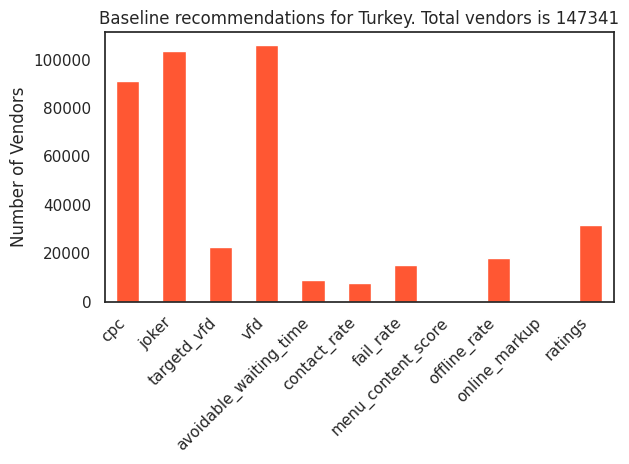

In [434]:
# begin with counts
 
# Create the bar plot
ax = df_b_tr[reco_columns_[:-3]].sum().plot(kind='bar', color=talabat_orange)

plt.xticks(rotation=45, ha='right')
total_vendors = df_b_tr.vendor_id.nunique()
plt.title(f"Baseline recommendations for Turkey. Total vendors is {total_vendors}")
plt.ylabel("Number of Vendors")
plt.tight_layout()
plt.show()

#plt.savefig('baseline_recommendations_plot_tb_ae.png')
#print("Plot saved as 'baseline_recommendations_plot.png'")



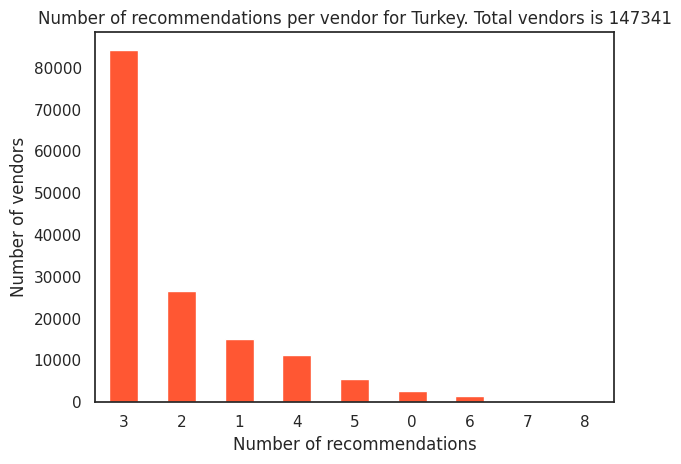

In [435]:
df_b_tr[reco_columns_[:-3]].sum(axis=1).value_counts()

# Create the bar plot
ax = df_b_tr[columns_[:-3]].sum(axis=1).value_counts().plot(kind='bar', color=talabat_orange)
total_vendors = df_b_tr.vendor_id.nunique()
plt.xticks(rotation=0)
plt.title(f"Number of recommendations per vendor for Turkey. Total vendors is {total_vendors}")
plt.ylabel("Number of vendors")
plt.xlabel("Number of recommendations")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Why do we need recommendations again?\nCorrelation between recommendations across vendors, Turkey')

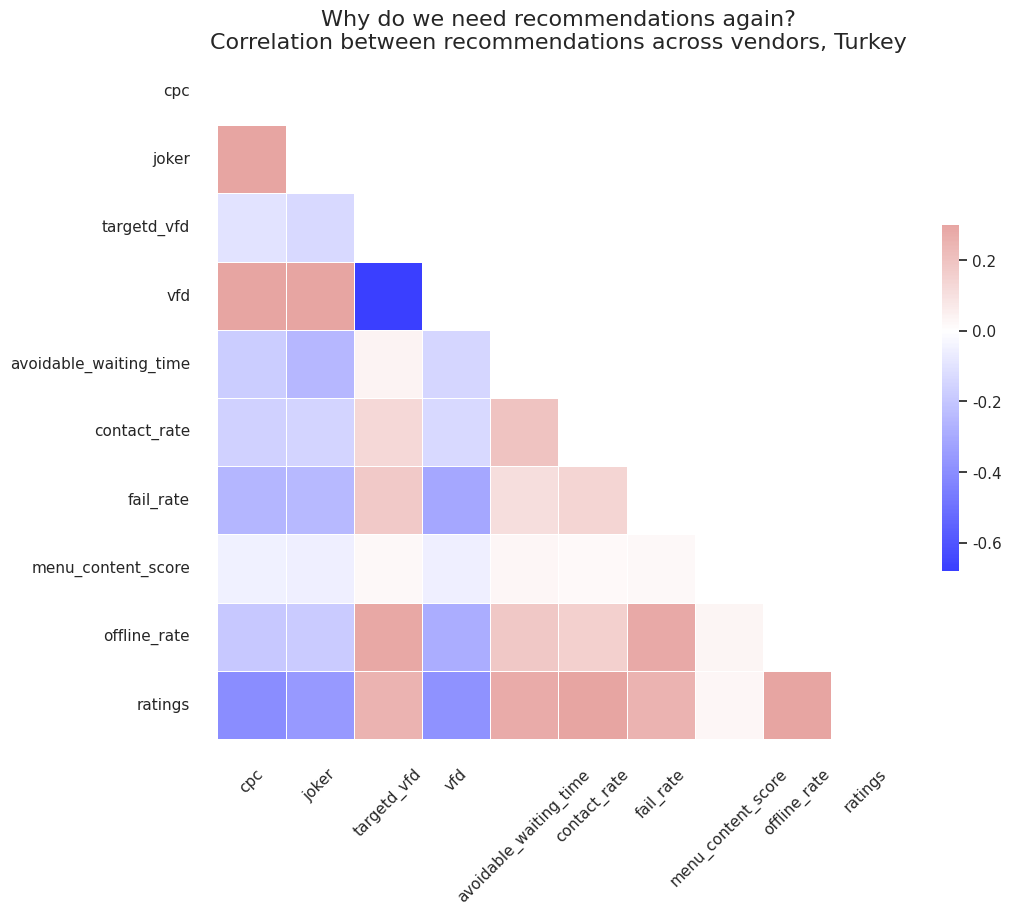

In [437]:
sum_series = df_b_tr[reco_columns_[:-3]].sum()
indices_gt_zero = sum_series[sum_series > 0].index.tolist()

corr = df_b_tr[indices_gt_zero].corr().fillna(0)
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
colors = [dh_navy, "white", dh_red] # Add "white" or a light color in the middle for divergence
nodes = [0, 0.5, 1.0] # Define the positions of each color (0=start, 0.5=middle, 1.0=end)
cmap = LinearSegmentedColormap.from_list("my_custom_cmap", list(zip(nodes, colors)))

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True,
                 linewidths=.5, cbar_kws={"shrink": .5})
ax.xaxis.set_tick_params(rotation=45, size=16)
ax.yaxis.set_tick_params(rotation=0, size=16)
plt.title("Why do we need recommendations again?\nCorrelation between recommendations across vendors, Turkey", fontsize=16)

In [ ]:
## current performance

In [439]:
%%bigquery df_performance
SELECT * FROM `dhh-ncr-stg.patrick_doupe.current_performance`
WHERE entity_id='YS_TR'

Query is running:   0%|          |

Downloading:   0%|          |

In [440]:
df_performance.head()

,report_date,updated_at,entity_id,vendor_code,chain_id,chain_name,region,city,area,vendor_grade,...,budget,is_active,vertical_food,is_new_vendor,new_customer_orders,retention_rate,total_orders,successful_orders,total_orders_gmv,successful_orders_gmv
0,2025-07-01,2025-07-10 11:59:29.622658+00:00,YS_TR,ADANA|e8a020c2-5531-41a4-ade2-ec9dee832724,None,None,MENA,ADANA,None,NA,...,None,False,FOOD,False,<NA>,NaN,<NA>,<NA>,None,None
1,2025-07-01,2025-07-10 11:59:29.622658+00:00,YS_TR,ADANA|302f2a9e-dc91-441d-8623-30e89b34bf8f,None,None,MENA,ADANA,None,NA,...,None,True,FOOD,False,<NA>,NaN,<NA>,<NA>,None,None
2,2025-07-01,2025-07-10 11:59:29.622658+00:00,YS_TR,ADANA|2f0969a9-46dc-47e4-9511-5261e4ad69f2,None,None,MENA,ADANA,None,NA,...,None,False,FOOD,False,<NA>,NaN,<NA>,<NA>,None,None
3,2025-07-01,2025-07-10 11:59:29.622658+00:00,YS_TR,ADANA|4553a70c-1241-4178-bfc6-d35acd38377e,None,None,MENA,ADANA,None,NA,...,None,False,FOOD,False,<NA>,NaN,<NA>,<NA>,None,None
4,2025-07-01,2025-07-10 11:59:29.622658+00:00,YS_TR,ADANA|26d657ab-fb13-4d40-a969-7bbede86349f,e7732260-872a-4e17-8366-7d052304516c,Usta Dönerci,MENA,ADANA,None,NA,...,None,True,FOOD,False,<NA>,NaN,<NA>,<NA>,None,None


In [441]:
df_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893463 entries, 0 to 893462
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype              
---  ------                 --------------   -----              
 0   report_date            893463 non-null  dbdate             
 1   updated_at             893463 non-null  datetime64[us, UTC]
 2   entity_id              893463 non-null  object             
 3   vendor_code            893463 non-null  object             
 4   chain_id               174547 non-null  object             
 5   chain_name             166558 non-null  object             
 6   region                 893463 non-null  object             
 7   city                   893463 non-null  object             
 8   area                   4483 non-null    object             
 9   vendor_grade           893463 non-null  object             
 10  cuisine_name           668122 non-null  object             
 11  budget                 541979 non-null 

In [442]:
df_performance['total_orders_gmv'] = pd.to_numeric(df_performance["total_orders_gmv"])
df_performance['successful_orders_gmv'] = pd.to_numeric(df_performance["successful_orders_gmv"])

In [443]:
df_p_tr = df_performance.loc[df_performance.entity_id == 'YS_TR'].copy()

In [444]:
df_p_tr = pd.merge(df_b_tr, df_p_tr, left_on = 'vendor_id', right_on='vendor_code', indicator=True)
df_p_tr.groupby('_merge')['vendor_id'].nunique()

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_84744/2241477849.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_p_tr.groupby('_merge')['vendor_id'].nunique()


_merge
left_only          0
right_only         0
both          147341
Name: vendor_id, dtype: int64

In [448]:
df_tr_active = df_p_tr[df_p_tr.is_active == True]
df_tr_active.columns
df_tr_active.loc[:, 'unsuccessful_orders_gmv'] = df_tr_active['total_orders_gmv'] - df_tr_active['successful_orders_gmv']
performance_columns = ['new_customer_orders', 'retention_rate', 'total_orders', 'successful_orders', 'total_orders_gmv', 'successful_orders_gmv', 'unsuccessful_orders_gmv']

df_tr_active.loc[:, performance_columns] = df_tr_active[performance_columns].fillna(
    value = {col : 0 for col in performance_columns}
)
for col in reco_columns_:
    df_tr_active.loc[:, col] = pd.to_numeric(df_tr_active[col], errors='coerce')

/var/folders/c_/xt8d51196jl46y09mq3j_3_w0000gq/T/ipykernel_84744/3443245209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tr_active.loc[:, 'unsuccessful_orders_gmv'] = df_tr_active['total_orders_gmv'] - df_tr_active['successful_orders_gmv']


In [449]:
df_tr_active.loc[df_tr_active.any_ops == 0, ]

,global_entity_id,vendor_id,created_date,cpc,joker,targetd_vfd,vfd,avoidable_waiting_time,contact_rate,fail_rate,...,vertical_food,is_new_vendor,new_customer_orders,retention_rate,total_orders,successful_orders,total_orders_gmv,successful_orders_gmv,_merge,unsuccessful_orders_gmv
0,YS_TR,erd9,2025-07-02,1,1,0,1,0,0,0,...,FOOD,False,0,0.0,0,0,0.00,0.0,both,0.00
1,YS_TR,erd9,2025-07-02,1,1,0,1,0,0,0,...,FOOD,False,0,0.0,0,0,0.00,0.0,both,0.00
2,YS_TR,jzdd,2025-07-02,1,1,0,1,0,0,0,...,FOOD,False,0,0.0,0,0,0.00,0.0,both,0.00
3,YS_TR,jzdd,2025-07-02,1,1,0,1,0,0,0,...,FOOD,False,0,0.0,0,0,0.00,0.0,both,0.00
4,YS_TR,TR_USAK|d4d9b63d-bed4-4b96-b743-327fb3dce51f,2025-07-02,1,1,0,1,0,0,0,...,FOOD,False,0,0.0,0,0,0.00,0.0,both,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422666,YS_TR,yx29,2025-07-02,0,0,0,0,0,0,0,...,FOOD,False,0,0.0,0,0,0.00,0.0,both,0.00
422667,YS_TR,kawh,2025-07-02,0,0,0,0,0,0,0,...,FOOD,False,0,0.0,1,0,7.18,0.0,both,7.18
422668,YS_TR,kawh,2025-07-02,0,0,0,0,0,0,0,...,FOOD,False,0,0.0,1,0,7.18,0.0,both,7.18
422669,YS_TR,kawh,2025-07-02,0,0,0,0,0,0,0,...,FOOD,False,0,0.0,58,0,461.31,0.0,both,461.31


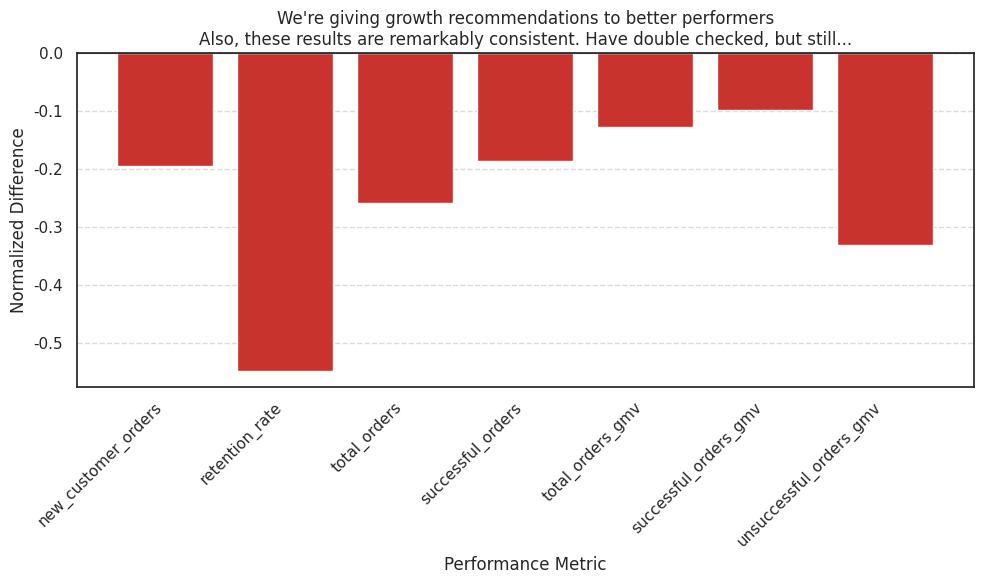

In [ ]:
grouped_means_any = df_tr_active.loc[df_tr_active.any_ops == 0, ].groupby("any_growth")[performance_columns].mean()
try:
    means_rec = grouped_means_any.loc[1]
    means_no_rec = grouped_means_any.loc[0]
    absolute_difference_means = means_rec - means_no_rec
except KeyError:
    print("Error: 'any_recommendation' group 0 or 1 not found. Cannot calculate difference.")

overall_means = df_ae_active[performance_columns].mean()

normalized_difference_means = absolute_difference_means / overall_means.replace(0, np.nan)

fig, ax = plt.subplots(figsize=(10, 6))

# Determine bar colors based on whether the difference is positive or negative
# Using dh_navy for positive impact, dh_red for negative impact
bar_colors = [dh_navy if diff <= 0 else dh_red for diff in difference_means]

ax.bar(performance_columns, normalized_difference_means, color=bar_colors)

# Add labels, title
ax.set_xlabel('Performance Metric')
ax.set_ylabel('Normalized Difference')
ax.set_title('We\'re giving growth recommendations to worse performers')
ax.grid(axis='y', linestyle='--', alpha=0.7)# Add a horizontal line at 0 for reference
ax.axhline(0, color='gray', linestyle='-', linewidth=0.8)

# Rotate x-axis labels if they are long
plt.xticks(rotation=45, ha='right')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [447]:
results = []
num_tests = (len(performance_columns) - 1) * len(reco_columns_) 

for r_col in reco_columns_:
    if r_col == 'cpc_top_up':
        pass
    else:
        for p_col in performance_columns:
            formula = f"{p_col} ~ {r_col}"
            model = smf.ols(formula, data=df_tr_active).fit()

            coef = model.params[f'{r_col}']
            t_stat = model.tvalues[f'{r_col}']
            p_value = model.pvalues[f'{r_col}']

            results.append({
                'Performance Column': p_col,
                'Recommendation Column': r_col,
                'Coefficient': round(coef, 2),
                'T-statistic': round(t_stat, 2),
                'P-value': round(p_value, 4)
            })
# Bonferroni correction
alpha = 0.05
bonferroni_corrected_alpha = alpha / num_tests

results_df = pd.DataFrame(results)

results_df.loc[:, 'sign_b'] = results_df['P-value'].apply(lambda x: True if x < bonferroni_corrected_alpha else False)

print("Linear Regression Results:")
print(results_df.to_string(index=False))
print(f"\nBonferroni Corrected p-value threshold (alpha = {alpha}, number of tests = {num_tests}): {bonferroni_corrected_alpha:.4f}")

NameError: name 'df_tr_active' is not defined

In [ ]:
# new cohort rules
BASIC = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1'
HIERARCHICAL = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v2'
BASIC_NO_CUISINE = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1_cuisine'
HIERARCHICAL_NO_CUISINE = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v2_cusine'
BASIC_MIN10 = 'logistics-vendor-production.pa_staging.smart_reco_active_cohorts_hierarchical_most_in_common_v1_10'

In [ ]:
base_sql_query = """
select * from (
select
*,
count(distinct concat(entity_id,vendor_code)) over (partition by cohort_id) as vendors,
from `{table_path}`
) where vendors>=5
"""

In [ ]:
# For current cohort rules 
TARGET_ENTITY = 'TB_AE'
CREATED_MONTH = '2025-07-01'
CURRENT_COHORT_PATH = 'dhh-ncr-stg.patrick_doupe.current_cohort_vendor_base'

NEW_SUMMARY_TABLE_ID = 'patrick_doupe.cohort_basic_hierarchy_statistics'
PROJECT_ID = 'dhh-ncr-stg'

current_query = """
    SELECT 
        global_entity_id AS entity_id,
        vendor_id AS vendor_code,
        cohort_id,
        COALESCE(gmv, 0) AS gmv 
    FROM `{path}` WHERE global_entity_id = '{target_entity}' AND DATE(created_month) = '{created_month}' 
"""

In [ ]:
df_basic = pandas_gbq.read_gbq(base_sql_query.format(table_path=BASIC))
df_h = pandas_gbq.read_gbq(base_sql_query.format(table_path=HIERARCHICAL))
df_basic_no_cuisine = pandas_gbq.read_gbq(base_sql_query.format(table_path=BASIC_NO_CUISINE))
df_h_no_cuisine = pandas_gbq.read_gbq(base_sql_query.format(table_path=HIERARCHICAL_NO_CUISINE))
df_basic_min10 = pandas_gbq.read_gbq(base_sql_query.format(table_path=BASIC_MIN10))

df_current = pandas_gbq.read_gbq(current_query.format(path=CURRENT_COHORT_PATH, target_entity=TARGET_ENTITY, created_month=CREATED_MONTH))

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|


In [ ]:
df_current['gmv'] = pd.to_numeric(df_current['gmv'], errors='coerce')

df_list_mapping = {
    'basic': df_basic,
    'basic_min10': df_basic_min10,
    'basic_no_c': df_basic_no_cuisine,
    'hierarchy': df_h,
    'hierarchy_no_cuisine': df_h_no_cuisine
}

# first process
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=PendingDeprecationWarning)
    processed_dfs = process_dataframes_with_gmv(
        original_df=df_current,
        dataframes_to_process=df_list_mapping,
    )

# then calculate statistics
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    outlier_summary_results = process_dataframes_for_outliers(
        processed_dfs,
        'gmv',
        'cohort_id'
    )

pandas_gbq.to_gbq(outlier_summary_results, NEW_SUMMARY_TABLE_ID, project_id=PROJECT_ID, if_exists='replace')

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/f_statistic.png


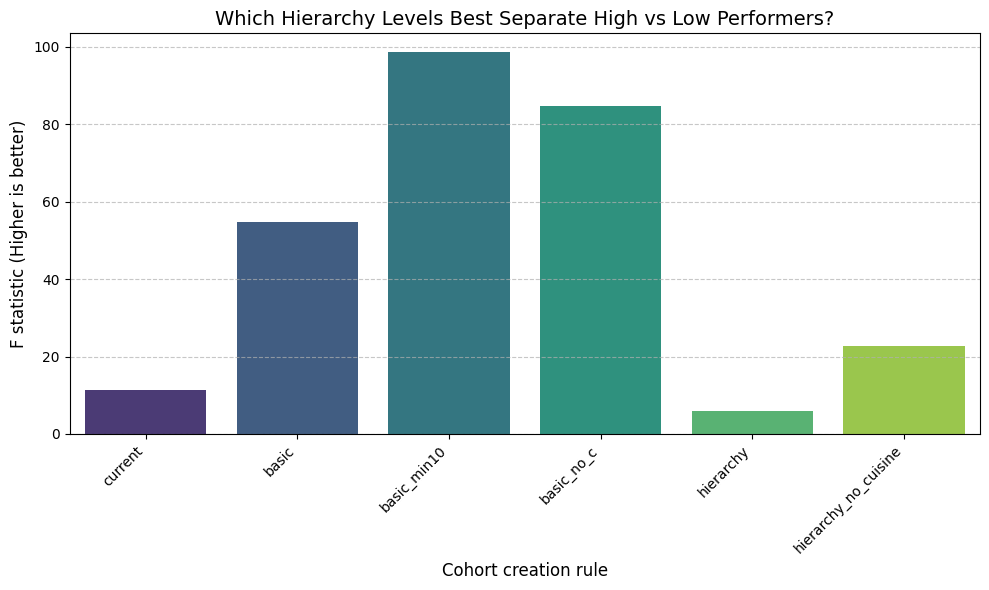

In [ ]:
STATISTIC='f_stat_manual'
Y_LABEL='F statistic (Higher is better)'
TITLE='Which Hierarchy Levels Best Separate High vs Low Performers?'
OUTPUT_PATH=BASE_PLOT_PATH / 'f_statistic.png'

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/share_cohorts_with_outlier_5x.png


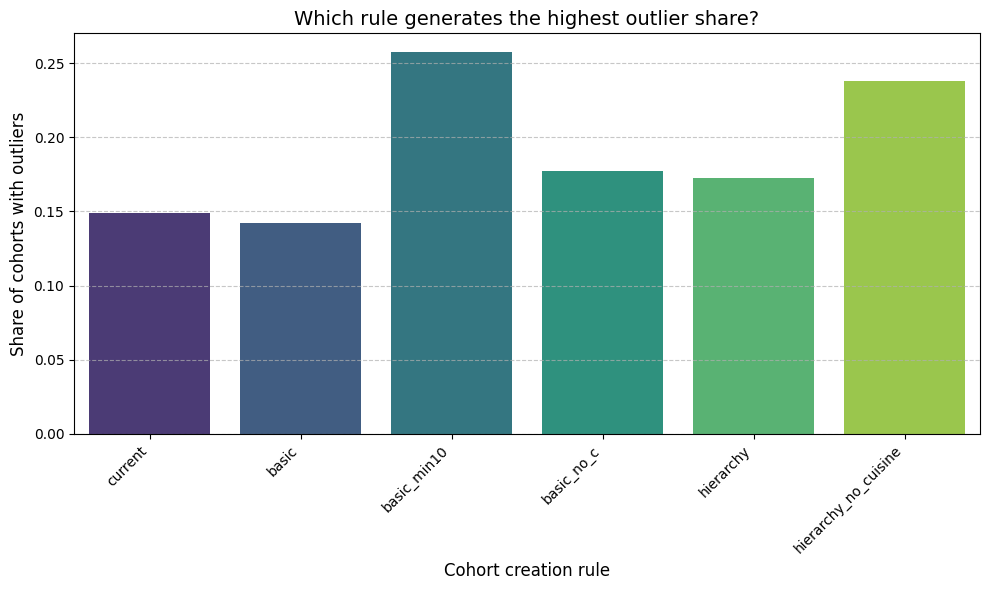

In [ ]:
STATISTIC='share_cohorts_with_outlier_5x'
Y_LABEL='Share of cohorts with outliers'
TITLE='Which rule generates the highest outlier share?'
OUTPUT_PATH=BASE_PLOT_PATH/ f"{STATISTIC}.png"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/ms_b_manual.png


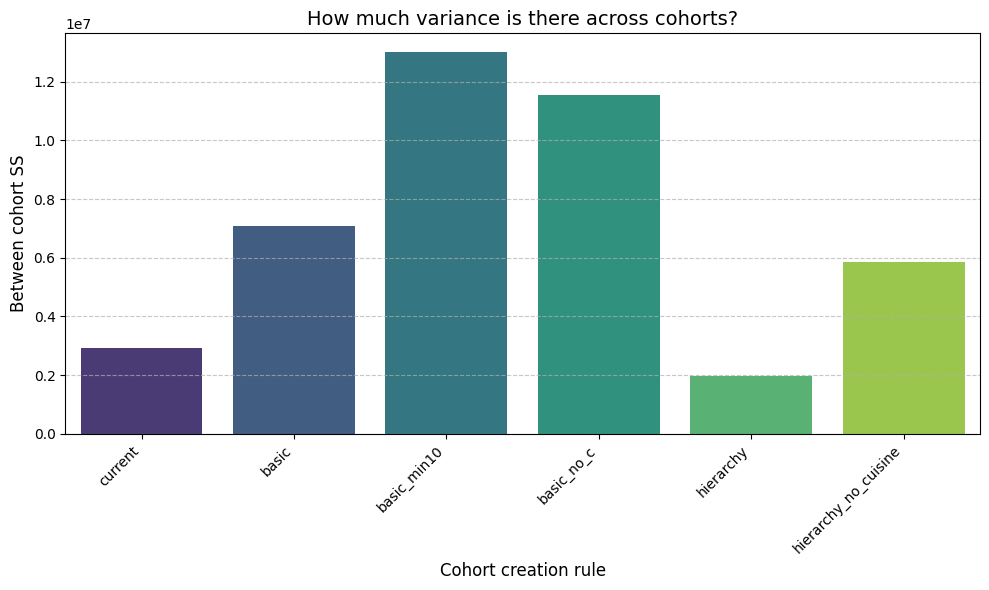

In [ ]:
STATISTIC='ms_b_manual'
Y_LABEL='Between cohort SS'
TITLE='How much variance is there across cohorts?'
OUTPUT_PATH=BASE_PLOT_PATH/ f"{STATISTIC}.png"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

Plot saved to: /Users/patrick.doupe/DH/ad_hoc/cohorts/figures/ms_w_manual.png


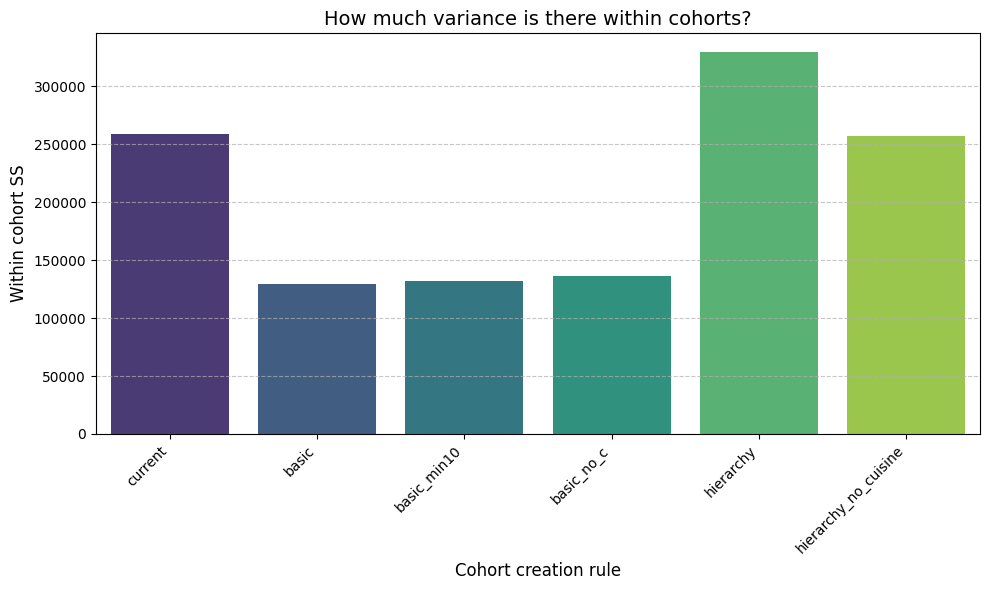

In [ ]:
STATISTIC='ms_w_manual'
Y_LABEL='Within cohort SS'
TITLE='How much variance is there within cohorts?'
OUTPUT_PATH=BASE_PLOT_PATH/ f"{STATISTIC}.png"

with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    plot_figure_wrapper(outlier_summary_results, STATISTIC, Y_LABEL, TITLE, OUTPUT_PATH)

In [ ]:
current_stats = compare_outlier_methods(df_current, 'gmv', 'cohort_id')
corrcoef = np.corrcoef(current_stats.cohort_size, current_stats.mean_5x_outliers)
print(f"The correlation between cohort size and the number of outliers in the current cohorting rule is {corrcoef[0][1]:.2f}")

The correlation between cohort size and the number of outliers in the current cohorting rule is 0.97


In [ ]:
df_b

In [ ]:
pretty_print_output(get_top_cohort_items(df_basic_no_cuisine))

Cohort ID: 74650
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 1088
------------------------------
Cohort ID: 94453
Features:
{
    "area": "Business Bay",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 568
------------------------------
Cohort ID: 107896
Features:
{
    "area": "Dubai Silicon Oasis",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 405
------------------------------
Cohort ID: 72367
Features:
{
    "area": "All",
    "budget": "All",
    "city": "abu dhabi",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 392
------------------------------
Cohort ID: 128348
Features:
{
    "area": "Jumeirah Lakes Towers - JLT",
    "budget": "All",
    "city": "dubai",
    

In [ ]:
pretty_print_output(get_top_cohort_items(df_basic_min10))

Cohort ID: 74650
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 373
------------------------------
Cohort ID: 74649
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 324
------------------------------
Cohort ID: 94454
Features:
{
    "area": "Business Bay",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 290
------------------------------
Cohort ID: 74952
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "Indian",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 268
------------------------------
Cohort ID: 74648
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
   

In [ ]:
pretty_print_output(get_top_cohort_items(df_h))

Cohort ID: 26274
Features:
{
    "area": "Al Karama",
    "budget": "All",
    "city": "dubai",
    "cuisine": "Indian",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 84
------------------------------
Cohort ID: 106811
Features:
{
    "area": "Dubai Motor City",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 67
------------------------------
Cohort ID: 94453
Features:
{
    "area": "Business Bay",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
    "entity": "tb_ae",
    "vendor_grade": "D"
}
Unique Vendors: 67
------------------------------
Cohort ID: 74953
Features:
{
    "area": "All",
    "budget": "All",
    "city": "dubai",
    "cuisine": "Indian",
    "entity": "tb_ae",
    "vendor_grade": "NA"
}
Unique Vendors: 65
------------------------------
Cohort ID: 8160
Features:
{
    "area": "Al Barsha 1",
    "budget": "All",
    "city": "dubai",
    "cuisine": "All",
 